# Forecasting Net Prophet

You’re a growth analyst at [MercadoLibre](http://investor.mercadolibre.com/about-us). With over 200 million users, MercadoLibre is the most popular e-commerce site in Latin America. You've been tasked with analyzing the company's financial and user data in clever ways to make the company grow. So, you want to find out if the ability to predict search traffic can translate into the ability to successfully trade the stock.

The instructions for this Challenge are divided into four steps, as follows:

* Step 1: Find unusual patterns in hourly Google search traffic

* Step 2: Mine the search traffic data for seasonality

* Step 3: Relate the search traffic to stock price patterns

* Step 4: Create a time series model with Prophet

The following subsections detail these steps.

## Install and import the required libraries and dependencies

In [1]:
# Install the required libraries
!pip install prophet

In [35]:
# Import the required libraries and dependencies
import pandas as pd
from prophet import Prophet
import datetime as dt
import numpy as np
%matplotlib inline

## Step 1: Find Unusual Patterns in Hourly Google Search Traffic

The data science manager asks if the Google search traffic for the company links to any financial events at the company. Or, does the search traffic data just present random noise? To answer this question, pick out any unusual patterns in the Google search data for the company, and connect them to the corporate financial events.

To do so, complete the following steps:

1. Read the search data into a DataFrame, and then slice the data to just the month of May 2020. (During this month, MercadoLibre released its quarterly financial results.) Visualize the results. Do any unusual patterns exist?

2. Calculate the total search traffic for the month, and then compare the value to the monthly median across all months. Did the Google search traffic increase during the month that MercadoLibre released its financial results?


#### Step 1: Read the search data into a DataFrame, and then slice the data to just the month of May 2020. (During this month, MercadoLibre released its quarterly financial results.) Visualize the results. Do any unusual patterns exist?

In [37]:
# Store the data in a Pandas DataFrame
# Set the "Date" column as the Datetime Index.

df_mercado_trends = pd.read_csv(
    "https://static.bc-edx.com/ai/ail-v-1-0/m8/lms/datasets/google_hourly_search_trends.csv",
    index_col='Date',
    parse_dates=True,
    infer_datetime_format=True
).dropna()

# Review the first and last five rows of the DataFrame
display(df_mercado_trends.head())
display(df_mercado_trends.tail())

<ipython-input-37-b9bc5439b517>:4: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df_mercado_trends = pd.read_csv(
<ipython-input-37-b9bc5439b517>:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_mercado_trends = pd.read_csv(


,Search Trends
Date,
2016-06-01 00:00:00,97
2016-06-01 01:00:00,92
2016-06-01 02:00:00,76
2016-06-01 03:00:00,60
2016-06-01 04:00:00,38


,Search Trends
Date,
2020-09-07 20:00:00,71
2020-09-07 21:00:00,83
2020-09-07 22:00:00,96
2020-09-07 23:00:00,97
2020-09-08 00:00:00,96


In [4]:
# Review the data types of the DataFrame using the info function
df_mercado_trends.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 37106 entries, 2016-06-01 00:00:00 to 2020-09-08 00:00:00
Data columns (total 1 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   Search Trends  37106 non-null  int64
dtypes: int64(1)
memory usage: 579.8 KB


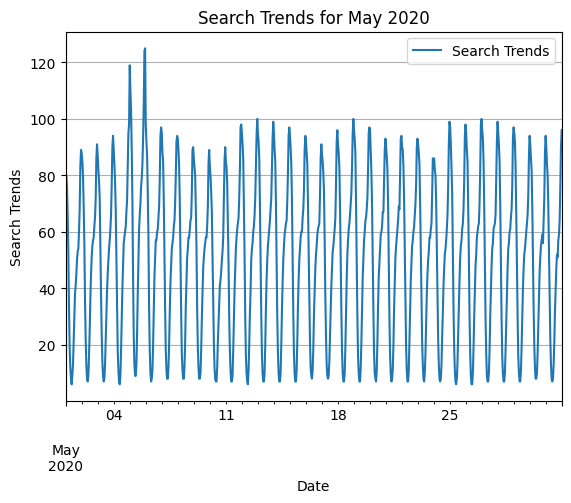

In [5]:
# Slice the DataFrame to just the month of May 2020
df_may_2020 = df_mercado_trends.loc['2020-05']
df_may_2020.head()
# Plot to visualize the data for May 2020
import matplotlib.pyplot as plt
df_may_2020['Search Trends'].plot()
plt.title('Search Trends for May 2020')
plt.xlabel('Date')
plt.ylabel('Search Trends')
plt.legend()
plt.grid(True)
plt.show()

#### Step 2: Calculate the total search traffic for the month, and then compare the value to the monthly median across all months. Did the Google search traffic increase during the month that MercadoLibre released its financial results?

In [6]:
# Calculate the sum of the total search traffic for May 2020
traffic_may_2020 = df_mercado_trends.loc['2020-05'].aggregate("sum")

# View the traffic_may_2020 value
traffic_may_2020

Search Trends    38181
dtype: int64

In [7]:
# Calcluate the monhtly median search traffic across all months
# Group the DataFrame by index year and then index month, chain the sum and then the median functions

median_monthly_traffic = df_mercado_trends.groupby([df_mercado_trends.index.year, df_mercado_trends.index.month]).sum().median()
# View the median_monthly_traffic value
median_monthly_traffic

Search Trends    35172.5
dtype: float64

In [8]:
# To compare the seach traffic for the month of May 2020 to the overall monthly median value,
# Divide the may traffic total by the median monthly traffic
print(traffic_may_2020/median_monthly_traffic)

Search Trends    1.085536
dtype: float64


##### Answer the following question:

**Question:** Did the Google search traffic increase during the month that MercadoLibre released its financial results?

**Answer:**  Yes.  Total search traffic for May 2020 is 38181 and monhtly median search traffic across all months is 35172.5

## Step 2: Mine the Search Traffic Data for Seasonality

Marketing realizes that they can use the hourly search data, too. If they can track and predict interest in the company and its platform for any time of day, they can focus their marketing efforts around the times that have the most traffic. This will get a greater return on investment (ROI) from their marketing budget.

To that end, you want to mine the search traffic data for predictable seasonal patterns of interest in the company. To do so, complete the following steps:

1. Group the hourly search data to plot the average traffic by the hour of day. Does the search traffic peak at a particular time of day or is it relatively consistent?

2. Group the hourly search data to plot the average traffic by the day of the week (for example, Monday vs. Friday). Does the search traffic get busiest on any particular day of the week?

3. Group the hourly search data to plot the average traffic by the week of the year. Does the search traffic tend to increase during the winter holiday period (weeks 40 through 52)?


#### Step 1: Group the hourly search data to plot the average traffic by the hour of the day.

In [9]:
flattened_df = df_mercado_trends.reset_index()


In [10]:
flattened_df.dtypes

Date             datetime64[ns]
Search Trends             int64
dtype: object

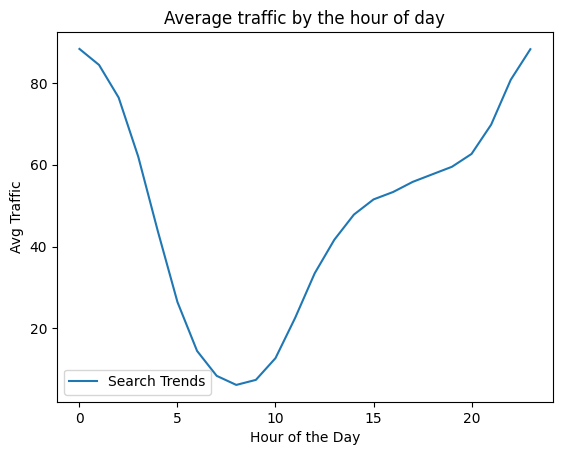

In [11]:

####Group the hourly search data to plot the average traffic by the hour of day.
flattened_df['Hour']= flattened_df['Date'].dt.hour
avg_traffic_by_hour_of_day= flattened_df.groupby('Hour')['Search Trends'].mean()
avg_traffic_by_hour_of_day.plot(kind='line')
plt.xlabel('Hour of the Day')
plt.ylabel('Avg Traffic')
plt.title('Average traffic by the hour of day')
plt.legend()
plt.show()


In [12]:
avg_traffic_by_hour_of_day= flattened_df.groupby('Hour')['Search Trends'].mean()
avg_traffic_by_hour_of_day

Hour
0     88.324289
1     84.408150
2     76.419793
3     61.954075
4     43.720569
5     26.406856
6     14.459897
7      8.371928
8      6.150712
9      7.384864
10    12.699871
11    22.523286
12    33.452781
13    41.648771
14    47.807891
15    51.516818
16    53.333765
17    55.810479
18    57.659767
19    59.500000
20    62.643596
21    69.803364
22    80.777490
23    88.258732
Name: Search Trends, dtype: float64

#### Step 2: Group the hourly search data to plot the average traffic by the day of the week (for example, Monday vs. Friday).

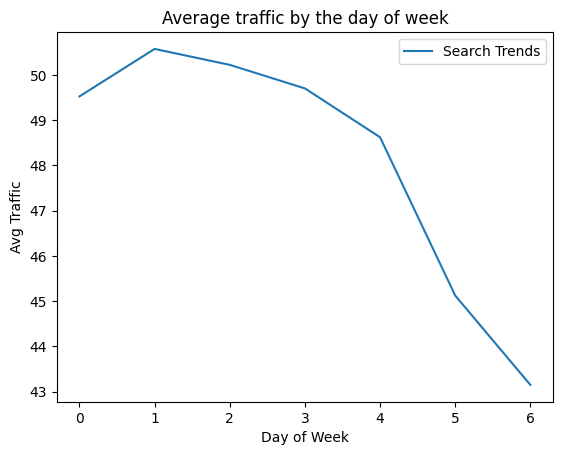

In [14]:
avg_traffic_by_day_of_week = flattened_df.groupby(flattened_df['Date'].dt.day_of_week)['Search Trends'].mean()
avg_traffic_by_day_of_week.plot(kind='line')
plt.xlabel('Day of Week')
plt.ylabel('Avg Traffic')
plt.title('Average traffic by the day of week')
plt.legend()
plt.show()


In [ ]:
avg_traffic_by_day_of_week = flattened_df.groupby(flattened_df['Date'].dt.day_of_week)['Search Trends'].mean()
avg_traffic_by_day_of_week

Date
0    49.522813
1    50.571672
2    50.219604
3    49.699661
4    48.621041
5    45.125377
6    43.151207
Name: Search Trends, dtype: float64

#### Step 3: Group the hourly search data to plot the average traffic by the week of the year.

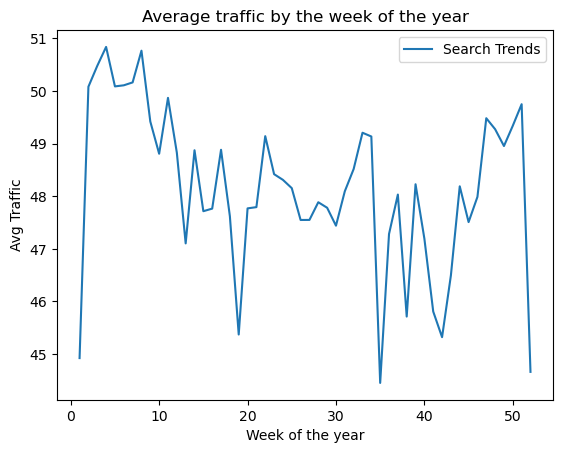

In [ ]:
#flattened_df['Week']= flattened_df['Date'].dt.weekofyear
#flattened_df['iso_year'] = flattened_df['Date'].dt.isocalendar().year
flattened_df['iso_week'] = flattened_df['Date'].dt.isocalendar().week

#avg_traffic_by_week = flattened_df.groupby(['iso_year','iso_week'])['Search Trends'].mean()
avg_traffic_by_week = flattened_df.groupby(['iso_week'])['Search Trends'].mean()


avg_traffic_by_week.plot(kind='line')
plt.xlabel('Week of the year')
plt.ylabel('Avg Traffic')
plt.title('Average traffic by the week of the year')
plt.legend()
plt.show()


In [ ]:
avg_traffic_by_week = flattened_df.groupby(['iso_week'])['Search Trends'].mean()
avg_traffic_by_week


iso_week
1     44.924107
2     50.078869
3     50.474702
4     50.834821
5     50.084821
6     50.105655
7     50.160714
8     50.763393
9     49.417722
10    48.805556
11    49.866987
12    48.827381
13    47.102679
14    48.872024
15    47.714286
16    47.763393
17    48.880952
18    47.619048
19    45.372024
20    47.767857
21    47.791667
22    49.140152
23    48.417857
24    48.309524
25    48.152381
26    47.547619
27    47.548810
28    47.884524
29    47.779762
30    47.439286
31    48.092857
32    48.515476
33    49.204762
34    49.133333
35    44.452381
36    47.280952
37    48.030129
38    45.712798
39    48.226190
40    47.191964
41    45.808036
42    45.321429
43    46.497024
44    48.187500
45    47.507440
46    47.986607
47    49.480655
48    49.272321
49    48.952381
50    49.337798
51    49.747024
52    44.662202
Name: Search Trends, dtype: float64

##### Answer the following question:

**Question:** Are there any time based trends that you can see in the data?

**Answer:**
-   The traffic peaks at 0th and 23rd hour of the day.

-   The traffic get busiest on Tuesday and Wedensday.

- The tracffic does no increase during winter holiday period (weeks 40 through 52) compared to weeks 2 through 8.

## Step 3: Relate the Search Traffic to Stock Price Patterns

You mention your work on the search traffic data during a meeting with people in the finance group at the company. They want to know if any relationship between the search data and the company stock price exists, and they ask if you can investigate.

To do so, complete the following steps:

1. Read in and plot the stock price data. Concatenate the stock price data to the search data in a single DataFrame.

2. Market events emerged during the year of 2020 that many companies found difficult. But, after the initial shock to global financial markets, new customers and revenue increased for e-commerce platforms. Slice the data to just the first half of 2020 (`2020-01` to `2020-06` in the DataFrame), and then plot the data. Do both time series indicate a common trend that’s consistent with this narrative?

3. Create a new column in the DataFrame named “Lagged Search Trends” that offsets, or shifts, the search traffic by one hour. Create two additional columns:

    * “Stock Volatility”, which holds an exponentially weighted four-hour rolling average of the company’s stock volatility

    * “Hourly Stock Return”, which holds the percent change of the company's stock price on an hourly basis

4. Review the time series correlation, and then answer the following question: Does a predictable relationship exist between the lagged search traffic and the stock volatility or between the lagged search traffic and the stock price returns?


#### Step 1: Read in and plot the stock price data. Concatenate the stock price data to the search data in a single DataFrame.

In [31]:
# Upload the "mercado_stock_price.csv" file into Colab, then store in a Pandas DataFrame
# Set the "date" column as the Datetime Index.
df_mercado_stock = pd.read_csv(
    "https://static.bc-edx.com/ai/ail-v-1-0/m8/lms/datasets/mercado_stock_price.csv",
    index_col="date",
    parse_dates=True,
    infer_datetime_format=True
).dropna()

# View the first and last five rows of the DataFrame
display(df_mercado_stock.head())
display(df_mercado_stock.tail())

<ipython-input-31-6a0218088829>:3: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df_mercado_stock = pd.read_csv(


,close
date,
2015-01-02 09:00:00,127.67
2015-01-02 10:00:00,125.44
2015-01-02 11:00:00,125.57
2015-01-02 12:00:00,125.40
2015-01-02 13:00:00,125.17


,close
date,
2020-07-31 11:00:00,1105.780
2020-07-31 12:00:00,1087.925
2020-07-31 13:00:00,1095.800
2020-07-31 14:00:00,1110.650
2020-07-31 15:00:00,1122.510


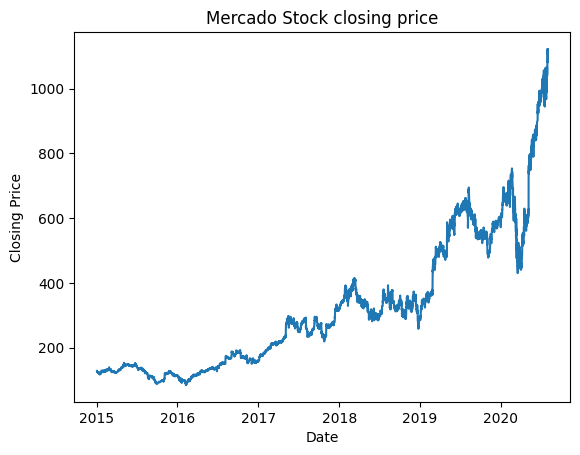

In [32]:
# Visualize the closing price of the df_mercado_stock DataFrame
plt.plot(df_mercado_stock['close'])
plt.title('Mercado Stock closing price')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.show()

In [38]:
# Concatenate the df_mercado_stock DataFrame with the df_mercado_trends DataFrame
concat_df = pd.concat([df_mercado_stock,df_mercado_trends],axis=1)
concat_df

,close,Search Trends
2015-01-02 09:00:00,127.67,NaN
2015-01-02 10:00:00,125.44,NaN
2015-01-02 11:00:00,125.57,NaN
2015-01-02 12:00:00,125.40,NaN
2015-01-02 13:00:00,125.17,NaN
...,...,...
2020-09-07 20:00:00,NaN,71.0
2020-09-07 21:00:00,NaN,83.0
2020-09-07 22:00:00,NaN,96.0
2020-09-07 23:00:00,NaN,97.0


In [39]:
# View the first and last five rows of the DataFrame
concat_df = concat_df.dropna(thresh=2)
print(concat_df.head())
print(concat_df.tail())

                      close  Search Trends
2016-06-01 09:00:00  135.16            6.0
2016-06-01 10:00:00  136.63           12.0
2016-06-01 11:00:00  136.56           22.0
2016-06-01 12:00:00  136.42           33.0
2016-06-01 13:00:00  136.10           40.0
                        close  Search Trends
2020-07-31 11:00:00  1105.780           20.0
2020-07-31 12:00:00  1087.925           32.0
2020-07-31 13:00:00  1095.800           41.0
2020-07-31 14:00:00  1110.650           47.0
2020-07-31 15:00:00  1122.510           53.0


#### Step 2: Market events emerged during the year of 2020 that many companies found difficult. But, after the initial shock to global financial markets, new customers and revenue increased for e-commerce platforms. Slice the data to just the first half of 2020 (`2020-01` to `2020-06` in the DataFrame), and then plot the data. Do both time series indicate a common trend that’s consistent with this narrative?

In [40]:
# For the combined dataframe, slice to just the first half of 2020 (2020-01 through 2020-06)
# View the first and last five rows of first_half_2020 DataFrame
sliced_df = concat_df['2020-01-01' :'2020-06-20']
print(sliced_df.head())
print(sliced_df.tail())

                       close  Search Trends
2020-01-02 09:00:00  601.085            9.0
2020-01-02 10:00:00  601.290           14.0
2020-01-02 11:00:00  615.410           25.0
2020-01-02 12:00:00  611.400           37.0
2020-01-02 13:00:00  611.830           50.0
                       close  Search Trends
2020-06-19 11:00:00  947.090           24.0
2020-06-19 12:00:00  946.815           40.0
2020-06-19 13:00:00  954.890           50.0
2020-06-19 14:00:00  960.680           56.0
2020-06-19 15:00:00  952.360           62.0


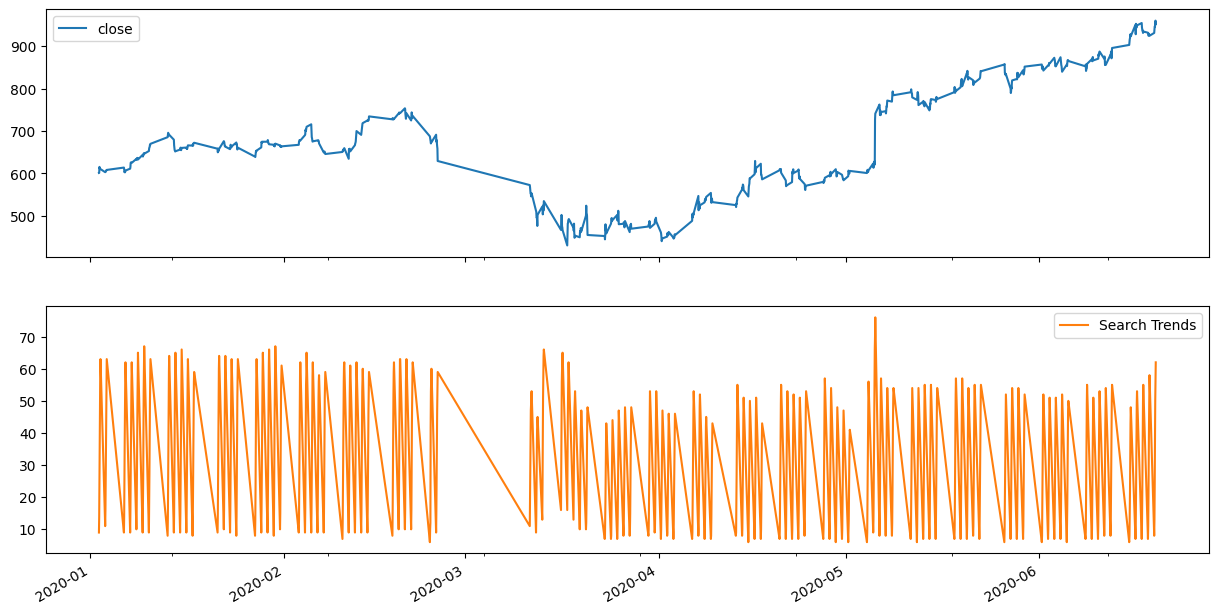

In [41]:

sliced_df.plot(subplots=True, figsize=(15,8))

plt.show()

In [ ]:
# Visualize the close and Search Trends data
# Plot each column on a separate axes using the following syntax
# `plot(subplots=True)`


##### Answer the following question:

**Question:** Do both time series indicate a common trend that’s consistent with this narrative?

**Answer:** In truth, our evidence of a common trend between search activity and stock price is pretty limited. It does appear generally however that the low point for Mercado Libre's stock price, late March to early April, did coincide with lower search activity for the firm. Search activity does pick up along with its stock price, although the stock price from mid-April onward definitively outpaces search interest.

There's one important thing to note: if you zoom in both graphs to the spike around May 5th, 2020, you'll find the date of the company's earnings release to the public. It looks like search traffic for the firm spiked about two hours before the firm's stock price spiked. This could indicate a predictable pattern (can Google Searches predict the stock price?), but an alternative explanation might just be that people tend to search for more information about the firm right before an earnings announcement gets released. We'd need to do a little more time-series research to see which explanation best fits the data.

#### Step 3: Create a new column in the DataFrame named “Lagged Search Trends” that offsets, or shifts, the search traffic by one hour. Create two additional columns:

* “Stock Volatility”, which holds an exponentially weighted four-hour rolling average of the company’s stock volatility

* “Hourly Stock Return”, which holds the percent change of the company's stock price on an hourly basis


In [42]:
# Create a new column in the mercado_stock_trends_df DataFrame called Lagged Search Trends
# This column should shift the Search Trends information by one hour
concat_df['Lagged Search Trends'] = concat_df['Search Trends'].shift(1)

concat_df.head()


<ipython-input-42-8af9403b43d0>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  concat_df['Lagged Search Trends'] = concat_df['Search Trends'].shift(1)


,close,Search Trends,Lagged Search Trends
2016-06-01 09:00:00,135.16,6.0,NaN
2016-06-01 10:00:00,136.63,12.0,6.0
2016-06-01 11:00:00,136.56,22.0,12.0
2016-06-01 12:00:00,136.42,33.0,22.0
2016-06-01 13:00:00,136.10,40.0,33.0


In [43]:
# Create a new column in the mercado_stock_trends_df DataFrame called Stock Volatility
# This column should calculate the standard deviation of the closing stock price return data over a 4 period rolling window
concat_df['Stock Volatility'] = concat_df['close'].rolling(window=4).std()
concat_df.head()




<ipython-input-43-337d922fe033>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  concat_df['Stock Volatility'] = concat_df['close'].rolling(window=4).std()


,close,Search Trends,Lagged Search Trends,Stock Volatility
2016-06-01 09:00:00,135.16,6.0,NaN,NaN
2016-06-01 10:00:00,136.63,12.0,6.0,NaN
2016-06-01 11:00:00,136.56,22.0,12.0,NaN
2016-06-01 12:00:00,136.42,33.0,22.0,0.693848
2016-06-01 13:00:00,136.10,40.0,33.0,0.235142


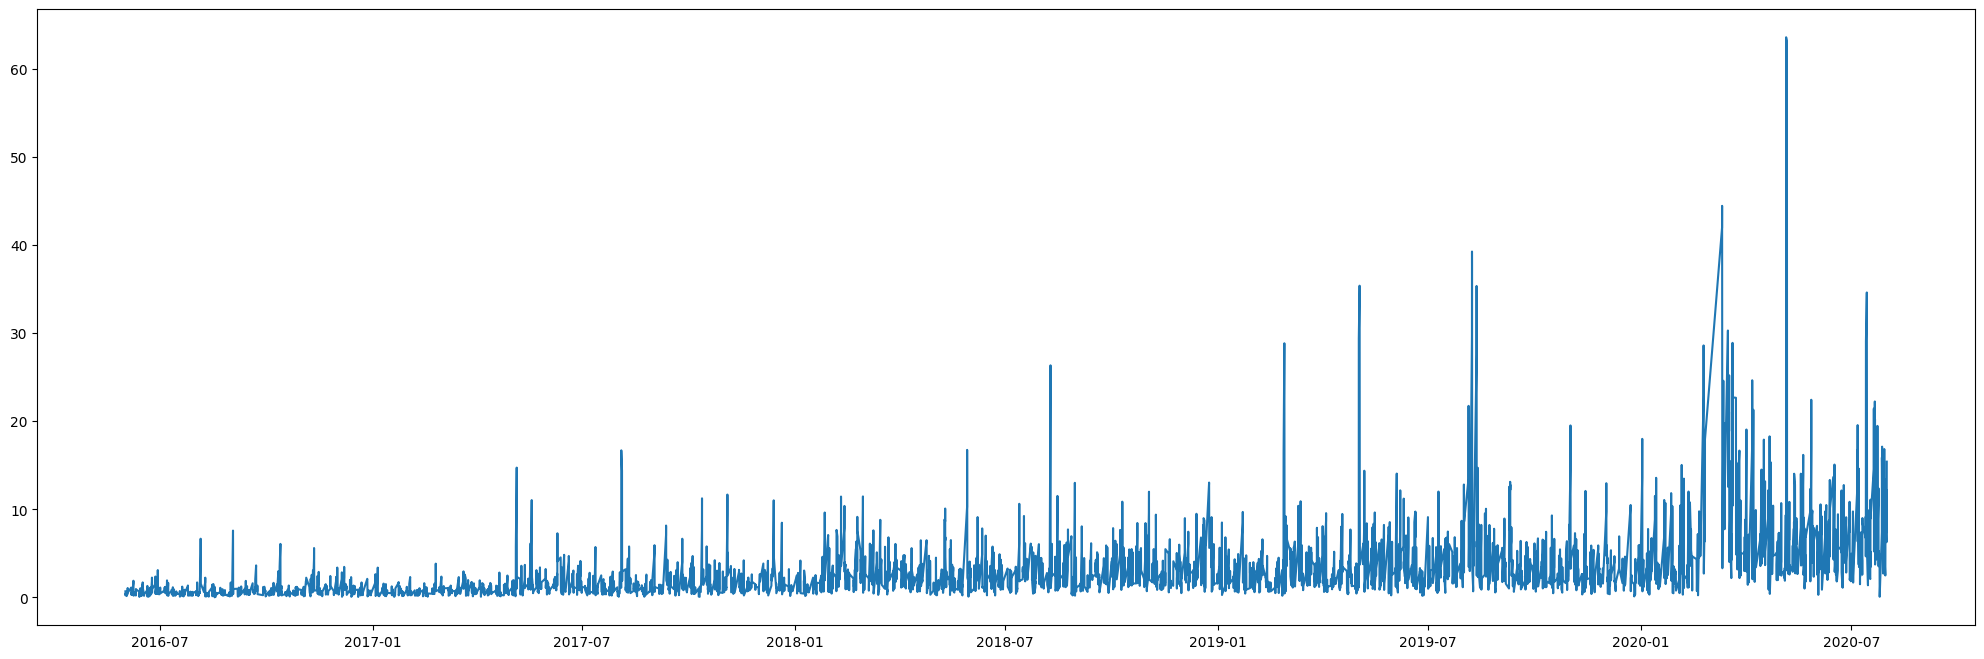

In [44]:
# Visualize the stock volatility
plt.figure(figsize=(25,8))
plt.plot(concat_df['Stock Volatility'])
plt.show()


**Solution Note:** Note how volatility spiked, and tended to stay high, during the first half of 2020. This is a common characteristic of volatility in stock returns worldwide: high volatility days tend to be followed by yet more high volatility days. When it rains, it pours.

In [45]:
# Create a new column in the mercado_stock_trends_df DataFrame called Hourly Stock Return
# This column should calculate hourly return percentage of the closing price
concat_df['Hourly Stock Return'] = concat_df['close'].pct_change()
concat_df

<ipython-input-45-fdd87128d68a>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  concat_df['Hourly Stock Return'] = concat_df['close'].pct_change()


,close,Search Trends,Lagged Search Trends,Stock Volatility,Hourly Stock Return
2016-06-01 09:00:00,135.160,6.0,NaN,NaN,NaN
2016-06-01 10:00:00,136.630,12.0,6.0,NaN,0.010876
2016-06-01 11:00:00,136.560,22.0,12.0,NaN,-0.000512
2016-06-01 12:00:00,136.420,33.0,22.0,0.693848,-0.001025
2016-06-01 13:00:00,136.100,40.0,33.0,0.235142,-0.002346
...,...,...,...,...,...
2020-07-31 11:00:00,1105.780,20.0,11.0,7.495900,0.006380
2020-07-31 12:00:00,1087.925,32.0,20.0,12.188462,-0.016147
2020-07-31 13:00:00,1095.800,41.0,32.0,7.393646,0.007239
2020-07-31 14:00:00,1110.650,47.0,41.0,10.169735,0.013552


In [46]:
# View the first and last five rows of the mercado_stock_trends_df DataFrame
print(df_mercado_trends.head())
print(df_mercado_trends.tail())

                     Search Trends
Date                              
2016-06-01 00:00:00             97
2016-06-01 01:00:00             92
2016-06-01 02:00:00             76
2016-06-01 03:00:00             60
2016-06-01 04:00:00             38
                     Search Trends
Date                              
2020-09-07 20:00:00             71
2020-09-07 21:00:00             83
2020-09-07 22:00:00             96
2020-09-07 23:00:00             97
2020-09-08 00:00:00             96


#### Step 4: Review the time series correlation, and then answer the following question: Does a predictable relationship exist between the lagged search traffic and the stock volatility or between the lagged search traffic and the stock price returns?

In [47]:
# Construct correlation table of Stock Volatility, Lagged Search Trends, and Hourly Stock Return
columns_for_correlation  = ['Stock Volatility' , 'Lagged Search Trends', 'Hourly Stock Return']
correlation_table_df = concat_df[columns_for_correlation].corr()
correlation_table_df

,Stock Volatility,Lagged Search Trends,Hourly Stock Return
Stock Volatility,1.000000,-0.118945,0.046723
Lagged Search Trends,-0.118945,1.000000,0.017929
Hourly Stock Return,0.046723,0.017929,1.000000


##### Answer the following question:


**Question:** Does a predictable relationship exist between the lagged search traffic and the stock volatility or between the lagged search traffic and the stock price returns?

**Answer:** If we read down the second column (or read along the second row), we see that there's a slight negative correlation between searches for the firm and its subsequent stock volatility. More searches (slightly) tend to indicate less near-term hourly stock risk for the firm.

On the other hand, there's a positive correlation between search activity in one hour and stock returns in the next: as search activity goes up, so will the firm's stock price in the short term. This effect is very weak though, only half the size of the effect on stock volatility. With the correlation so close to zero, some might also say that there's almost no relationship between these two variables whatsoever, and that the small findings that we do have could be just due to chance. While there's no required threshold when looking at correlation between stock returns and the variables used to predict them, it does tend to be that correlations in this context tend to be very low across the board. It's hard to predict the market!

## Step 4: Create a Time Series Model with Prophet

Now, you need to produce a time series model that analyzes and forecasts patterns in the hourly search data. To do so, complete the following steps:

1. Set up the Google search data for a Prophet forecasting model.

2. After estimating the model, plot the forecast. How's the near-term forecast for the popularity of MercadoLibre?

3. Plot the individual time series components of the model to answer the following questions:

    * What time of day exhibits the greatest popularity?

    * Which day of the week gets the most search traffic?

    * What's the lowest point for search traffic in the calendar year?


#### Step 1: Set up the Google search data for a Prophet forecasting model.

In [48]:
# Using the df_mercado_trends DataFrame, reset the index so the date information is no longer the index
mercado_prophet_df = df_mercado_trends.reset_index()
#mercado_prophet_df['Date']=pd.to_datetime(mercado_prophet_df['Date']).dt.date
# Label the columns ds and y so that the syntax is recognized by Prophet
mercado_prophet_df = mercado_prophet_df.rename(columns={'Date': 'ds', 'Search Trends' : 'y'})

# Drop an NaN values from the prophet_df DataFrame
mercado_prophet_df=mercado_prophet_df.dropna()

# View the first and last five rows of the mercado_prophet_df DataFrame
print(mercado_prophet_df.head())
print(mercado_prophet_df.tail())

                   ds   y
0 2016-06-01 00:00:00  97
1 2016-06-01 01:00:00  92
2 2016-06-01 02:00:00  76
3 2016-06-01 03:00:00  60
4 2016-06-01 04:00:00  38
                       ds   y
37101 2020-09-07 20:00:00  71
37102 2020-09-07 21:00:00  83
37103 2020-09-07 22:00:00  96
37104 2020-09-07 23:00:00  97
37105 2020-09-08 00:00:00  96


In [49]:
mercado_prophet_df.dtypes

ds    datetime64[ns]
y              int64
dtype: object

In [50]:
from pandas import to_datetime
mercado_prophet_df['ds']= to_datetime(mercado_prophet_df['ds'])

In [51]:
mercado_prophet_df.dtypes

ds    datetime64[ns]
y              int64
dtype: object

In [52]:
# Call the Prophet function, store as an object
prophet_model_obj = Prophet()

In [53]:
# Fit the time-series model.


prophet_model_obj.fit(mercado_prophet_df)

DEBUG:cmdstanpy:input tempfile: /tmp/tmpyaptedz9/apiu7rzr.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyaptedz9/q00q1394.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=41190', 'data', 'file=/tmp/tmpyaptedz9/apiu7rzr.json', 'init=/tmp/tmpyaptedz9/q00q1394.json', 'output', 'file=/tmp/tmpyaptedz9/prophet_modelum2ezep1/prophet_model-20240413185616.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:56:16 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:56:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [55]:
# Create a future dataframe to hold predictions
# Make the prediction go out as far as 2000 hours (approx 80 days)
future_mercado_trends = prophet_model_obj.make_future_dataframe(periods=2000, freq='H')

# View the last five rows of the future_mercado_trends DataFrame
future_mercado_trends.tail()

,ds
39101,2020-11-30 04:00:00
39102,2020-11-30 05:00:00
39103,2020-11-30 06:00:00
39104,2020-11-30 07:00:00
39105,2020-11-30 08:00:00


In [57]:
future_mercado_trends.dtypes


ds    datetime64[ns]
dtype: object

In [66]:
forecast_mercado_trends = prophet_model_obj.predict(future_mercado_trends)
forecast_mercado_trends.dtypes

ds                            datetime64[ns]
trend                                float64
yhat_lower                           float64
yhat_upper                           float64
trend_lower                          float64
trend_upper                          float64
additive_terms                       float64
additive_terms_lower                 float64
additive_terms_upper                 float64
daily                                float64
daily_lower                          float64
daily_upper                          float64
weekly                               float64
weekly_lower                         float64
weekly_upper                         float64
yearly                               float64
yearly_lower                         float64
yearly_upper                         float64
multiplicative_terms                 float64
multiplicative_terms_lower           float64
multiplicative_terms_upper           float64
yhat                                 float64
dtype: obj

In [73]:
# Make the predictions for the trend data using the future_mercado_trends DataFrame
forecast_mercado_trends = prophet_model_obj.predict(future_mercado_trends)
#forecast_mercado_trends.dtypes

# Display the first five rows of the forecast_mercado_trends DataFrame
forecast_mercado_trends.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2016-06-01 00:00:00,44.469500,81.324802,97.825637,44.469500,44.469500,45.159722,45.159722,45.159722,41.452703,...,1.860594,1.860594,1.860594,1.846426,1.846426,1.846426,0.0,0.0,0.0,89.629222
1,2016-06-01 01:00:00,44.470406,77.301450,93.981167,44.470406,44.470406,41.605529,41.605529,41.605529,37.943556,...,1.810498,1.810498,1.810498,1.851474,1.851474,1.851474,0.0,0.0,0.0,86.075935
2,2016-06-01 02:00:00,44.471312,66.153617,84.104735,44.471312,44.471312,31.282049,31.282049,31.282049,27.656646,...,1.768912,1.768912,1.768912,1.856491,1.856491,1.856491,0.0,0.0,0.0,75.753361
3,2016-06-01 03:00:00,44.472218,52.127720,69.027019,44.472218,44.472218,16.014826,16.014826,16.014826,12.417424,...,1.735926,1.735926,1.735926,1.861476,1.861476,1.861476,0.0,0.0,0.0,60.487045
4,2016-06-01 04:00:00,44.473124,35.154541,51.286413,44.473124,44.473124,-1.100073,-1.100073,-1.100073,-4.677999,...,1.711496,1.711496,1.711496,1.866430,1.866430,1.866430,0.0,0.0,0.0,43.373051


#### Step 2: After estimating the model, plot the forecast. How's the near-term forecast for the popularity of MercadoLibre?

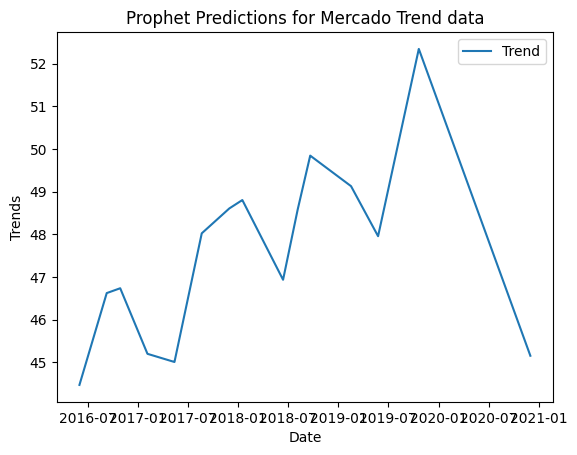

In [74]:
# Plot the Prophet predictions for the Mercado trends data
plt.plot(forecast_mercado_trends['ds'], forecast_mercado_trends['trend'], label = 'Trend')
plt.title('Prophet Predictions for Mercado Trend data')
plt.xlabel('Date')
plt.ylabel('Trends')
plt.legend()
plt.show()

##### Answer the following question:

**Question:**  How's the near-term forecast for the popularity of MercadoLibre?

**Answer:** Near-term forecst for trends does not look good.


#### Step 3: Plot the individual time series components of the model to answer the following questions:

* What time of day exhibits the greatest popularity?

* Which day of the week gets the most search traffic?

* What's the lowest point for search traffic in the calendar year?


In [75]:
forecast_mercado_trends.dtypes

ds                            datetime64[ns]
trend                                float64
yhat_lower                           float64
yhat_upper                           float64
trend_lower                          float64
trend_upper                          float64
additive_terms                       float64
additive_terms_lower                 float64
additive_terms_upper                 float64
daily                                float64
daily_lower                          float64
daily_upper                          float64
weekly                               float64
weekly_lower                         float64
weekly_upper                         float64
yearly                               float64
yearly_lower                         float64
yearly_upper                         float64
multiplicative_terms                 float64
multiplicative_terms_lower           float64
multiplicative_terms_upper           float64
yhat                                 float64
dtype: obj

In [83]:
# Set the index in the forecast_mercado_trends DataFrame to the ds datetime column
forecast_mercado_trends.index = pd.to_datetime(forecast_mercado_trends.index)

# View the only the yhat,yhat_lower and yhat_upper columns from the DataFrame
yhat_data = forecast_mercado_trends[['yhat', 'yhat_lower','yhat_upper']]

yhat_data


,yhat,yhat_lower,yhat_upper
ds,,,
2016-06-01 00:00:00,89.629222,81.324802,97.825637
2016-06-01 01:00:00,86.075935,77.301450,93.981167
2016-06-01 02:00:00,75.753361,66.153617,84.104735
2016-06-01 03:00:00,60.487045,52.127720,69.027019
2016-06-01 04:00:00,43.373051,35.154541,51.286413
...,...,...,...
2020-11-30 04:00:00,39.781638,31.156389,48.054632
2020-11-30 05:00:00,24.310504,15.416915,32.973542
2020-11-30 06:00:00,12.344836,3.759407,21.264862


Solutions Note: `yhat` represents the most likely (average) forecast, whereas `yhat_lower` and `yhat_upper` represents the worst and best case prediction (based on what are known as 95% confidence intervals).

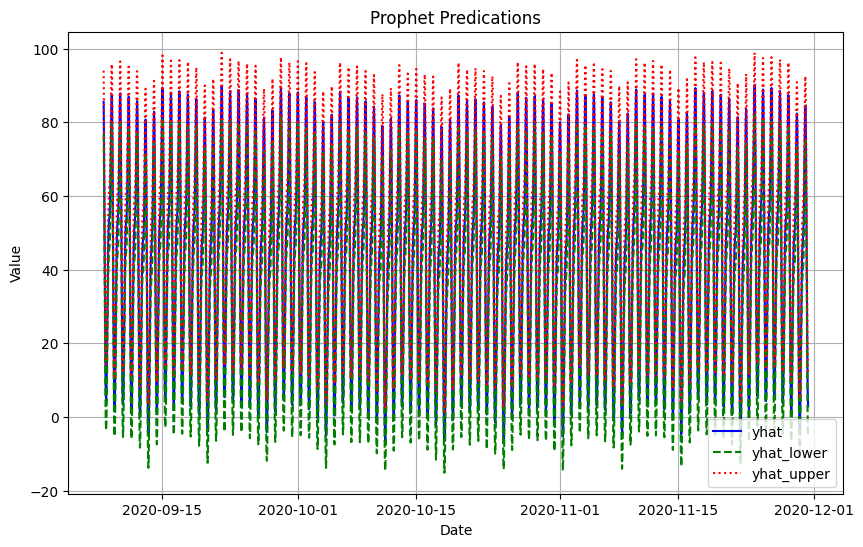

In [95]:
# From the forecast_mercado_trends DataFrame, plot the data to visualize
#  the yhat, yhat_lower, and yhat_upper columns over the last 2000 hours
plt.figure(figsize=(10,6))
plt.plot(forecast_mercado_trends.index[-2000:], forecast_mercado_trends['yhat'][-2000:], label='yhat',color='blue')
plt.plot(forecast_mercado_trends.index[-2000:], forecast_mercado_trends['yhat_lower'][-2000:], label='yhat',color='green', linestyle = '--')
plt.plot(forecast_mercado_trends.index[-2000:], forecast_mercado_trends['yhat_upper'][-2000:], label='yhat',color='red', linestyle = ':')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Prophet Predications')
plt.legend(['yhat', 'yhat_lower', 'yhat_upper'])
plt.grid(True)
plt.show()





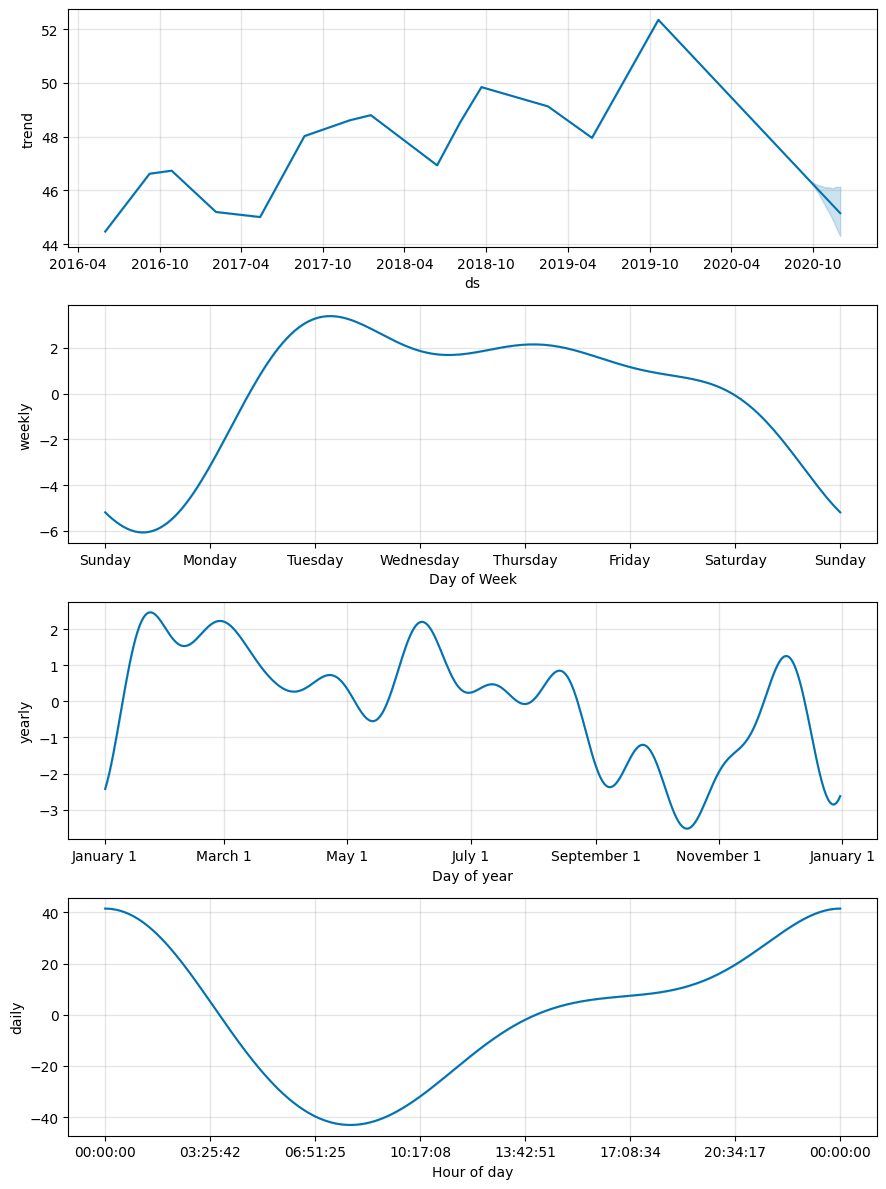

In [103]:
# Reset the index in the forecast_mercado_trends DataFrame
forecast_mercado_trends.reset_index(inplace=True)

# Use the plot_components function to visualize the forecast results
# for the forecast_canada DataFrame
fig = prophet_model_obj.plot_components(forecast_mercado_trends)
plt.show()



##### Answer the following questions:

**Question:** What time of day exhibits the greatest popularity?

**Answer:** 0th and 23rd hours

**Question:** Which day of week gets the most search traffic?
   
**Answer:** Tuesday

**Question:** What's the lowest point for search traffic in the calendar year?

**Answer:** Around mid Oct
